In [1]:
# Import Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from scipy import stats

In [2]:
#!pip install census

In [3]:
# Load in Hate Crime csv from FBI Crime Data Explorer - Hate Crime Specific.
hate_crime_csv = pd.read_csv("Resources/hate_crime.csv", low_memory=False)
hate_crime_df = pd.DataFrame(hate_crime_csv)
hate_crime_df.head()

,INCIDENT_ID,DATA_YEAR,ORI,PUB_AGENCY_NAME,PUB_AGENCY_UNIT,AGENCY_TYPE_NAME,STATE_ABBR,STATE_NAME,DIVISION_NAME,REGION_NAME,...,OFFENDER_RACE,OFFENDER_ETHNICITY,VICTIM_COUNT,OFFENSE_NAME,TOTAL_INDIVIDUAL_VICTIMS,LOCATION_NAME,BIAS_DESC,VICTIM_TYPES,MULTIPLE_OFFENSE,MULTIPLE_BIAS
0,3015,1991,AR0040200,Rogers,NaN,City,AR,Arkansas,West South Central,South,...,White,NaN,1,Intimidation,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-Black or African American,Individual,S,S
1,3016,1991,AR0290100,Hope,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,1,Simple Assault,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-White,Individual,S,S
2,43,1991,AR0350100,Pine Bluff,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,1,Aggravated Assault,1.0,Residence/Home,Anti-Black or African American,Individual,S,S
3,44,1991,AR0350100,Pine Bluff,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,2,Aggravated Assault;Destruction/Damage/Vandalis...,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-White,Individual,M,S
4,3017,1991,AR0350100,Pine Bluff,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,1,Aggravated Assault,1.0,Service/Gas Station,Anti-White,Individual,S,S


### Reduce DF to include only neccessary columns.

In [4]:
columns = ['INCIDENT_ID', 'DATA_YEAR', 'INCIDENT_DATE', 'PUB_AGENCY_NAME', 'AGENCY_TYPE_NAME',
           'STATE_ABBR', 'STATE_NAME', 'POPULATION_GROUP_DESC', 'TOTAL_OFFENDER_COUNT',
           'TOTAL_INDIVIDUAL_VICTIMS', 'LOCATION_NAME', 'BIAS_DESC', 'VICTIM_TYPES'
          ]

reduced_hate_crime_df = hate_crime_df.loc[:,  columns]

# Filter Data: 2009

In [5]:
# Filter DF for 2009 only.
reduced_hate_crime_2009_df = reduced_hate_crime_df.loc[(reduced_hate_crime_df['DATA_YEAR'] == 2009)]
reduced_hate_crime_2009_df.head()

,INCIDENT_ID,DATA_YEAR,INCIDENT_DATE,PUB_AGENCY_NAME,AGENCY_TYPE_NAME,STATE_ABBR,STATE_NAME,POPULATION_GROUP_DESC,TOTAL_OFFENDER_COUNT,TOTAL_INDIVIDUAL_VICTIMS,LOCATION_NAME,BIAS_DESC,VICTIM_TYPES
136964,141003,2009,17-Feb-09,Anchorage,City,AK,Alaska,"Cities from 250,000 thru 499,999",1,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-American Indian or Alaska Native,Individual
136965,141004,2009,30-Jun-09,Anchorage,City,AK,Alaska,"Cities from 250,000 thru 499,999",0,1.0,Residence/Home,"Anti-Lesbian, Gay, Bisexual, or Transgender (M...",Individual
136966,141005,2009,5-Aug-09,Anchorage,City,AK,Alaska,"Cities from 250,000 thru 499,999",2,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-American Indian or Alaska Native,Individual
136967,141006,2009,28-Aug-09,Anchorage,City,AK,Alaska,"Cities from 250,000 thru 499,999",3,4.0,Highway/Road/Alley/Street/Sidewalk,Anti-American Indian or Alaska Native,Individual
136968,141007,2009,28-Aug-09,Anchorage,City,AK,Alaska,"Cities from 250,000 thru 499,999",2,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-American Indian or Alaska Native,Individual


In [6]:
# Create new DF for 2009 from value counts. Total number of hate crimes committed per state.

states2009 = reduced_hate_crime_2009_df['STATE_NAME'].value_counts(sort=True)
state_hatecrime_2009_df = pd.DataFrame(states2009)
state_hatecrime_2009_df = state_hatecrime_2009_df.reset_index()
state_hatecrime_2009_df.columns = ['State', 'Hate Crimes Committed']
state_hatecrime_2009_df.head()

,State,Hate Crimes Committed
0,California,1018
1,New York,641
2,New Jersey,549
3,Massachusetts,317
4,Michigan,315


In [8]:
# Census imports for 2012.

from census import Census
from us import states

# Census API Key
# Data not available for 2010 0r 2011.
from config import api_key
c = Census(api_key, year=2012)
# c.acs5.tables()

In [9]:
# Run Census Search to retrieve data on all states
# Note: not all data pulled from census api will be used for socioeconomic analysis.

census_data = c.acs5.get(("NAME", "B19013_001E", "B19301_001E", "B23025_005E", "B23025_002E",
                          "B17001_002E", "B17001_003E", "B17001_017E",
                          "B17001A_002E", "B17001B_002E", "B01003_001E",
                          "B02001_002E", "B02001_003E", "B15003_017E", "B15003_022E"), {'for': 'state:*'})

census_df = pd.DataFrame(census_data)

census_df = census_df.rename(columns={"B19301_001E": "Per Capita Income",
                                      "B19013_001E": "Median Household Income",
                                      "B23025_005E": "Unemployment Count",
                                      "B23025_002E": "Labor Force Size",
                                      "B17001_002E": "Poverty Count",
                                      "B17001_003E": "Poverty: Male",
                                      "B17001_017E": "Poverty: Female",
                                      "B17001A_002E": "Poverty: White",
                                      "B17001B_002E": "Poverty: Black",
                                      "B01003_001E": "Total Population",
                                      "B02001_002E": "Population: White",
                                      "B02001_003E": "Population: Black",
                                      "B15003_017E": "Education: High School",
                                      "B15003_022E": "Education: Bachelors",
                                      "NAME": "State", "state": "State Number"})

# Calculate & add in Poverty Rate (Poverty Count / Population)
census_df["Poverty Rate"] = 100 * \
    census_df["Poverty Count"].astype(
        int) / census_df["Total Population"].astype(int)

# Calculate & add in Unemployment Rate (Unemployment Count / Labor Force)
census_df["Unemployment Rate"] = 100 * \
    census_df["Unemployment Count"].astype(
        int) / census_df["Labor Force Size"].astype(int)

# Calculate and add share of population with at least a high school diploma.
census_df['Share of Population with HS Diploma'] = 1 - \
    census_df['Education: High School'].astype(
        int) / census_df['Total Population'].astype(int)

census_df = census_df[["State", "Total Population", "Median Household Income", "Per Capita Income", "Unemployment Rate",
                         "Poverty Rate", "Share of Population with HS Diploma"]]

In [11]:
census_df.head()

,State,Total Population,Median Household Income,Per Capita Income,Unemployment Rate,Poverty Rate,Share of Population with HS Diploma
0,Alabama,4777326.0,43160.0,23587.0,10.188838,17.631035,0.828741
1,Alaska,711139.0,69917.0,32537.0,8.045603,9.369617,0.861117
2,Arizona,6410979.0,50256.0,25571.0,9.711096,16.767891,0.867727
3,Arkansas,2916372.0,40531.0,22007.0,8.521134,18.183860,0.808218
4,California,37325068.0,61400.0,29551.0,10.942019,14.976798,0.880476


In [12]:
# Read in GINI index for 2009.
# Note: A higher Gini index indicates greater inequality,
# with high income individuals receiving much larger percentages of the total income of the population.
gini2009_csv = pd.read_csv('Resources/GINI2009.csv')

# Merge csv with census DF on State.
census_df = pd.merge(census_df, gini2009_csv, how='left', on='State')

# Merge Hate Crime DF with census DF.
clean_hate_crime_2009_df = pd.merge(census_df, state_hatecrime_2009_df, how="left", on="State")

In [13]:
# Replace NaN values for states w/ no data (reported hate crimes) with 0.
# Hawaii is now the only stat w/ no data (reported hate crimes).
values = {'Hate Crimes Committed': 0}
clean_hate_crime_2009_df = clean_hate_crime_2009_df.fillna(value=values)
#clean_hate_crime_2009_df

In [14]:
# Drop Puerto Rico from DF.
# Drop Hawaii from DF.
clean_hate_crime_2009_df = clean_hate_crime_2009_df.drop([51])
clean_hate_crime_2009_df = clean_hate_crime_2009_df.drop([11])

In [15]:
# Calculate 2009 Hate Crime Rate per 100,000 total population.
# https://oag.ca.gov/sites/all/files/agweb/pdfs/cjsc/prof10/formulas.pdf
# Note:	 Calculating rates for geographies of less than 100,000 will generate an inflated rate
# when compared to geographies with populations of 100,000 or more; therefore,
# rates are not calculated for geographies with populations of less than 100,000.

clean_hate_crime_2009_df['Hate Crime Rate per 100,000 Population'] = 100000 * \
    clean_hate_crime_2009_df['Hate Crimes Committed'].astype(
        int) / clean_hate_crime_2009_df['Total Population'].astype(int)

# Sort descending on Hate Crime Rate.
clean_hate_crime_2009_df = clean_hate_crime_2009_df.sort_values(by='Hate Crime Rate per 100,000 Population', ascending=False)
clean_hate_crime_2009_df = clean_hate_crime_2009_df.reset_index(drop=True)
clean_hate_crime_2009_df

#clean_hate_crime_2009_df.to_csv('hate_crime_socioeconomic_2009.csv')
clean_hate_crime_2009_df.head()

,State,Total Population,Median Household Income,Per Capita Income,Unemployment Rate,Poverty Rate,Share of Population with HS Diploma,Gini Index,Hate Crimes Committed,"Hate Crime Rate per 100,000 Population"
0,New Jersey,8793888.0,71637.0,35928.0,9.488355,9.672161,0.819232,0.465,549.0,6.242972
1,District of Columbia,605759.0,64267.0,45004.0,10.410046,17.433666,0.887934,0.532,37.0,6.108040
2,Connecticut,3572213.0,69519.0,37807.0,9.116630,9.647129,0.832210,0.480,200.0,5.598770
3,South Dakota,815871.0,49091.0,25570.0,4.909060,13.276486,0.820752,0.452,42.0,5.147873
4,Massachusetts,6560595.0,66658.0,35485.0,8.453433,10.643638,0.843351,0.468,317.0,4.831879


# Filter Data: 2017

In [16]:
# Filter DF for 2017 only.
reduced_hate_crime_2017_df = reduced_hate_crime_df.loc[(reduced_hate_crime_df['DATA_YEAR'] == 2017)]
reduced_hate_crime_2017_df.head()

,INCIDENT_ID,DATA_YEAR,INCIDENT_DATE,PUB_AGENCY_NAME,AGENCY_TYPE_NAME,STATE_ABBR,STATE_NAME,POPULATION_GROUP_DESC,TOTAL_OFFENDER_COUNT,TOTAL_INDIVIDUAL_VICTIMS,LOCATION_NAME,BIAS_DESC,VICTIM_TYPES
186860,279156,2017,29-Oct-17,Anchorage,City,AK,Alaska,"Cities from 250,000 thru 499,999",1,1.0,Amusement Park,Anti-White,Individual
186861,194491,2017,22-Dec-17,Juneau,City,AK,Alaska,"Cities from 25,000 thru 49,999",1,1.0,Residence/Home,Anti-White,Individual
186862,194492,2017,24-Oct-17,Juneau,City,AK,Alaska,"Cities from 25,000 thru 49,999",0,NaN,School-College/University,"Anti-Multiple Races, Group",Government
186863,194686,2017,4-May-17,State Troopers,State Police,AK,Alaska,"Non-MSA counties 100,000 or over",0,NaN,Church/Synagogue/Temple/Mosque,Anti-Other Christian,Religious Organization
186864,280686,2017,31-Jan-17,Hoover,City,AL,Alabama,"Cities from 50,000 thru 99,000",0,1.0,Grocery/Supermarket,Anti-Hispanic or Latino,Individual


In [17]:
# Create new DF for 2017 from value counts. Total number of hate crimes committed per state.
states2017 = reduced_hate_crime_2017_df['STATE_NAME'].value_counts(sort=True)
state_hatecrime_2017_df = pd.DataFrame(states2017)
state_hatecrime_2017_df = state_hatecrime_2017_df.reset_index()
state_hatecrime_2017_df.columns = ['State', 'Hate Crimes Committed']
state_hatecrime_2017_df.head()

,State,Hate Crimes Committed
0,California,1094
1,New York,554
2,Washington,511
3,New Jersey,499
4,Michigan,457


In [18]:
# Census imports for 2016.

c = Census(api_key, year=2016)

In [19]:
# Run Census Search to retrieve data on all states

census_data = c.acs5.get(("NAME", "B19013_001E", "B19301_001E", "B23025_005E", "B23025_002E",
                          "B17001_002E", "B17001_003E", "B17001_017E",
                          "B17001A_002E", "B17001B_002E", "B01003_001E",
                          "B02001_002E", "B02001_003E", "B15003_017E", "B15003_022E"), {'for': 'state:*'})

census_df = pd.DataFrame(census_data)

census_df = census_df.rename(columns={"B19301_001E": "Per Capita Income",
                                      "B19013_001E": "Median Household Income",
                                      "B23025_005E": "Unemployment Count",
                                      "B23025_002E": "Labor Force Size",
                                      "B17001_002E": "Poverty Count",
                                      "B17001_003E": "Poverty: Male",
                                      "B17001_017E": "Poverty: Female",
                                      "B17001A_002E": "Poverty: White",
                                      "B17001B_002E": "Poverty: Black",
                                      "B01003_001E": "Total Population",
                                      "B02001_002E": "Population: White",
                                      "B02001_003E": "Population: Black",
                                      "B15003_017E": "Education: High School",
                                      "B15003_022E": "Education: Bachelors",
                                      "NAME": "State", "state": "State Number"})

# Calculate & add in Poverty Rate (Poverty Count / Population)
census_df["Poverty Rate"] = 100 * \
    census_df["Poverty Count"].astype(
        int) / census_df["Total Population"].astype(int)

# Calculate & add in Unemployment Rate (Unemployment Count / Labor Force)
census_df["Unemployment Rate"] = 100 * \
    census_df["Unemployment Count"].astype(
        int) / census_df["Labor Force Size"].astype(int)

# Calculate and add share of population with at least a high school diploma.
census_df['Share of Population with HS Diploma'] = 1 - \
    census_df['Education: High School'].astype(
        int) / census_df['Total Population'].astype(int)


census_df = census_df[["State", "Total Population", "Median Household Income", "Per Capita Income", "Unemployment Rate",
                         "Poverty Rate", "Share of Population with HS Diploma"]]

census_df.head()

,State,Total Population,Median Household Income,Per Capita Income,Unemployment Rate,Poverty Rate,Share of Population with HS Diploma
0,Alabama,4841164.0,44758.0,24736.0,8.240621,17.943329,0.828924
1,Alaska,736855.0,74444.0,34191.0,7.525813,9.883356,0.855916
2,Arizona,6728577.0,51340.0,26686.0,7.943898,17.323663,0.866442
3,Arkansas,2968472.0,42336.0,23401.0,6.831175,18.273071,0.810969
4,California,38654206.0,63783.0,31458.0,8.682885,15.533257,0.878971


In [21]:
# Read in GINI index for 2017.
gini2017_csv = pd.read_csv('Resources/GINI2017.csv')

# Merge csv with census DF on State.
census_df = pd.merge(census_df, gini2017_csv, how='left', on='State')

# Merge Hate Crime DF with census DF.
clean_hate_crime_2017_df = pd.merge(census_df, state_hatecrime_2017_df, how="left", on="State")
clean_hate_crime_2017_df.head()

,State,Total Population,Median Household Income,Per Capita Income,Unemployment Rate,Poverty Rate,Share of Population with HS Diploma,Gini Index_x,Gini Index_y,Hate Crimes Committed
0,Alabama,4841164.0,44758.0,24736.0,8.240621,17.943329,0.828924,0.4768,0.4768,10.0
1,Alaska,736855.0,74444.0,34191.0,7.525813,9.883356,0.855916,0.4241,0.4241,4.0
2,Arizona,6728577.0,51340.0,26686.0,7.943898,17.323663,0.866442,0.4668,0.4668,264.0
3,Arkansas,2968472.0,42336.0,23401.0,6.831175,18.273071,0.810969,0.4725,0.4725,26.0
4,California,38654206.0,63783.0,31458.0,8.682885,15.533257,0.878971,0.4866,0.4866,1094.0


In [42]:
# Replace NaN values for states w/ no data (reported hate crimes) with 0.
# Hawaii is now the only stat w/ no data (reported hate crimes).
values = {'Hate Crimes Committed': 0}
clean_hate_crime_2017_df = clean_hate_crime_2017_df.fillna(value=values)
clean_hate_crime_2017_df

,State,Total Population,Median Household Income,Per Capita Income,Unemployment Rate,Poverty Rate,Share of Population with HS Diploma,Gini Index_x,Gini Index_y,Hate Crimes Committed,"Hate Crime Rate per 100,000 Population",total_crimes_2017,share_per_state_2017
0,District of Columbia,659009.0,72935.0,48781.0,8.654845,17.004320,0.891784,0.5281,0.5281,194.0,29.438141,7334.0,2.645214
1,Kentucky,4411989.0,44811.0,24802.0,7.504868,18.226224,0.821654,0.4784,0.4784,378.0,8.567564,7334.0,5.154077
2,Washington,7073146.0,62848.0,32999.0,6.753284,12.487456,0.871189,0.4561,0.4561,511.0,7.224508,7334.0,6.967548
3,Massachusetts,6742143.0,70954.0,38069.0,6.772892,10.988138,0.846865,0.4851,0.4851,434.0,6.437122,7334.0,5.917644
4,New Jersey,8915456.0,73702.0,37538.0,7.848944,10.648261,0.824021,0.4794,0.4794,499.0,5.597022,7334.0,6.803927
5,Vermont,626249.0,56104.0,30663.0,4.956633,11.125447,0.816666,0.4525,0.4525,34.0,5.429150,7334.0,0.463594
6,Michigan,9909600.0,50803.0,27549.0,8.485464,15.894345,0.827432,0.4671,0.4671,457.0,4.611690,7334.0,6.231252
7,Arizona,6728577.0,51340.0,26686.0,7.943898,17.323663,0.866442,0.4668,0.4668,264.0,3.923564,7334.0,3.599673
8,Oregon,3982267.0,53270.0,28822.0,8.056216,15.423953,0.866535,0.4593,0.4593,148.0,3.716476,7334.0,2.017998
9,Ohio,11586941.0,50674.0,27800.0,7.237560,14.955103,0.797004,0.4642,0.4642,386.0,3.331337,7334.0,5.263158


In [23]:
# Drop Puerto Rico/Hawaii from DF.
clean_hate_crime_2017_df = clean_hate_crime_2017_df.drop([51])
clean_hate_crime_2017_df = clean_hate_crime_2017_df.drop([11])

In [24]:
# Calculate 2017 Hate Crime Rate per 100,000 total population.
# https://oag.ca.gov/sites/all/files/agweb/pdfs/cjsc/prof10/formulas.pdf
# Note:	 Calculating rates for geographies of less than 100,000 will generate an inflated rate
# when compared to geographies with populations of 100,000 or more; therefore,
# rates are not calculated for geographies with populations of less than 100,000.

# Check Washington, D.C. on calculation, or if this is a result of massive increase in reported hate crimes!!!!!!

clean_hate_crime_2017_df['Hate Crime Rate per 100,000 Population'] = 100000 * \
    clean_hate_crime_2017_df['Hate Crimes Committed'].astype(
        int) / clean_hate_crime_2017_df['Total Population'].astype(int)

# Sort descending on Hate Crime Rate.
clean_hate_crime_2017_df = clean_hate_crime_2017_df.sort_values(by='Hate Crime Rate per 100,000 Population', ascending=False)
clean_hate_crime_2017_df = clean_hate_crime_2017_df.reset_index(drop=True)

#clean_hate_crime_2017_df.to_csv('hate_crime_socioeconomic_2017.csv')
clean_hate_crime_2017_df.head()

,State,Total Population,Median Household Income,Per Capita Income,Unemployment Rate,Poverty Rate,Share of Population with HS Diploma,Gini Index_x,Gini Index_y,Hate Crimes Committed,"Hate Crime Rate per 100,000 Population"
0,District of Columbia,659009.0,72935.0,48781.0,8.654845,17.004320,0.891784,0.5281,0.5281,194.0,29.438141
1,Kentucky,4411989.0,44811.0,24802.0,7.504868,18.226224,0.821654,0.4784,0.4784,378.0,8.567564
2,Washington,7073146.0,62848.0,32999.0,6.753284,12.487456,0.871189,0.4561,0.4561,511.0,7.224508
3,Massachusetts,6742143.0,70954.0,38069.0,6.772892,10.988138,0.846865,0.4851,0.4851,434.0,6.437122
4,New Jersey,8915456.0,73702.0,37538.0,7.848944,10.648261,0.824021,0.4794,0.4794,499.0,5.597022


# Hate Crime Analysis: 2009

In [25]:
clean_hate_crime_2009_df.describe()

,Total Population,Median Household Income,Per Capita Income,Unemployment Rate,Poverty Rate,Share of Population with HS Diploma,Gini Index,Hate Crimes Committed,"Hate Crime Rate per 100,000 Population"
count,5.000000e+01,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,6.155520e+06,53039.680000,27867.320000,8.483381,14.021739,0.834003,0.452580,132.240000,2.456107
std,6.874164e+06,8574.555181,4658.848349,1.907964,2.989209,0.027136,0.022322,181.865566,1.606616
min,5.628030e+05,38882.000000,20670.000000,3.317506,8.182325,0.760106,0.402000,2.000000,0.067394
25%,1.833100e+06,47088.500000,24669.000000,7.142008,11.854240,0.819301,0.435250,29.750000,1.125782
50%,4.434886e+06,51327.000000,26534.000000,8.490517,14.158877,0.834731,0.453000,67.500000,2.293228
75%,6.694184e+06,58224.000000,29937.000000,9.710563,16.671222,0.848299,0.466500,153.000000,3.415625
max,3.732507e+07,72999.000000,45004.000000,12.574643,21.570551,0.887934,0.532000,1018.000000,6.242972


In [26]:
# Basic stats: 

# Total hate crimes for year (per state).
clean_hate_crime_2009_df['total_crimes_2009'] = clean_hate_crime_2009_df['Hate Crimes Committed'].sum()


# Percent of hate crimes committed per state.
clean_hate_crime_2009_df['share_per_state_2009'] = clean_hate_crime_2009_df['Hate Crimes Committed'] / clean_hate_crime_2009_df['total_crimes_2009'] * 100

summary_2009_df = clean_hate_crime_2009_df[["State", "share_per_state_2009", 'Hate Crimes Committed',
                                            'total_crimes_2009', 'Hate Crime Rate per 100,000 Population'
                                            ]]

summary_2009_df = summary_2009_df.rename(columns={"total_crimes_2009": "Total Hate Crimes",
                                                  "share_per_state_2009": "Share per State (%)"
                                                })

# Add year to DF for merge and group by year analysis.
summary_2009_df['Year'] = '2009'

# Sort by share per state in order to get 
summary_2009_df = summary_2009_df.sort_values(by='Share per State (%)', ascending=False)
summary_2009_df = summary_2009_df.reset_index(drop=True)
summary_2009_df = summary_2009_df.round(2)
summary_2009_df

,State,Share per State (%),Hate Crimes Committed,Total Hate Crimes,"Hate Crime Rate per 100,000 Population",Year
0,California,15.40,1018.0,6612.0,2.73,2009
1,New York,9.69,641.0,6612.0,3.30,2009
2,New Jersey,8.30,549.0,6612.0,6.24,2009
3,Massachusetts,4.79,317.0,6612.0,4.83,2009
4,Michigan,4.76,315.0,6612.0,3.18,2009
5,Ohio,4.58,303.0,6612.0,2.63,2009
6,Arizona,3.31,219.0,6612.0,3.42,2009
7,Washington,3.15,208.0,6612.0,3.09,2009
8,Colorado,3.15,208.0,6612.0,4.12,2009
9,Connecticut,3.02,200.0,6612.0,5.60,2009


In [27]:
# Get top 5 states w/ highest count.
max_incidents_2009 = summary_2009_df.head()
top_incident_count_2009 = max_incidents_2009['Hate Crimes Committed'].sum()
top_incident_percent_2009 = max_incidents_2009['Share per State (%)'].sum()
print(f'Total Count of Hate Crimes Among Top 5 in 2009: {top_incident_count_2009}.')
print(f'Total Share of Hate Crimes Among Top 5 in 2009: {top_incident_percent_2009}%.')

Total Count of Hate Crimes Among Top 5 in 2009: 2840.0.
Total Share of Hate Crimes Among Top 5 in 2009: 42.94%.


#### Hate Crime Rate vs. Per Capita Income - 2009

* There does appear to be a positive relationship between the Hate Crime Rate and Per Capita Income. As per capita income increases, as does the hate crime rate.

* The state with the second highest hate crime rate, D.C., has the highest per capita income in 2009.

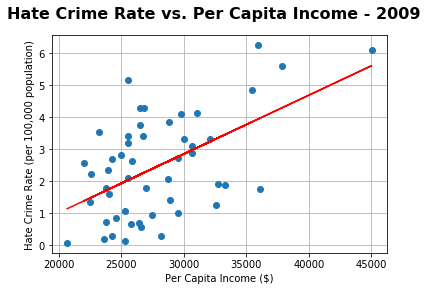

In [28]:
y = clean_hate_crime_2009_df['Hate Crime Rate per 100,000 Population']
x = clean_hate_crime_2009_df['Per Capita Income']

pcincome_slope, pcincome_int, pcincome_r, pcincome_p, pcincome_std_err = stats.linregress(
    x, y)
pcincome_fit = pcincome_slope * x + pcincome_int

fig, ax = plt.subplots()

fig.suptitle("Hate Crime Rate vs. Per Capita Income - 2009", fontsize=16, fontweight="bold")
ax.set_ylabel("Hate Crime Rate (per 100,000 population)")
ax.set_xlabel("Per Capita Income ($)")

ax.plot(x, y, linewidth=0, marker='o')
ax.plot(x, pcincome_fit, 'b-', c='r')
ax.grid()

plt.savefig('Images/Hate Crime Rate vs. Per Capita Income - 2009.png')
plt.show()

#### Hate Crime Rate per 100,000 Population vs. Median Household Income - 2009

* There does appear to be a positive relationship between the Hate Crime Rate and Median Household Income. As median household income increases, as does the hate crime rate.

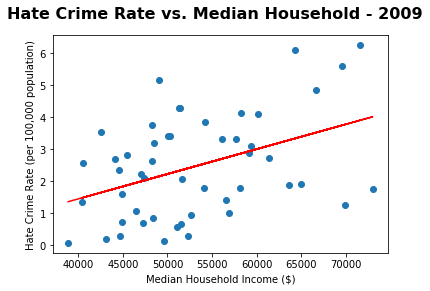

In [29]:
y = clean_hate_crime_2009_df['Hate Crime Rate per 100,000 Population']
x = clean_hate_crime_2009_df['Median Household Income']

midincome_slope, midincome_int, midincome_r, midincome_p, midincome_std_err = stats.linregress(
    x, y)
midincome_fit = midincome_slope * x + midincome_int

fig, ax = plt.subplots()

fig.suptitle("Hate Crime Rate vs. Median Household - 2009", fontsize=16, fontweight="bold")
ax.set_ylabel("Hate Crime Rate (per 100,000 population)")
ax.set_xlabel("Median Household Income ($)")

ax.plot(x, y, linewidth=0, marker='o')
ax.plot(x, midincome_fit, 'b-', c='r')

plt.savefig('Images/Hate Crime Rate vs. Median Household Income - 2009.png')
plt.show()

#### Hate Crime Rate per 100,000 Population vs. Unemployment Rate - 2009

* According to 2009 data, there does not appear to be a strong relationship between Hate Crime Rates and Unemployment rates.

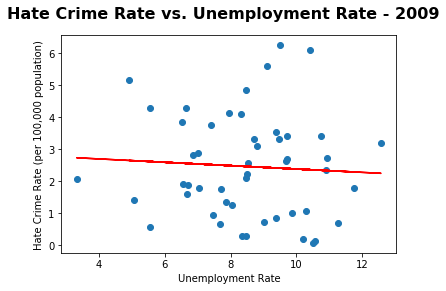

In [30]:
y = clean_hate_crime_2009_df['Hate Crime Rate per 100,000 Population']
x = clean_hate_crime_2009_df['Unemployment Rate']

unemp_slope, unemp_int, unemp_r, unemp_p, unemp_std_err = stats.linregress(
    x, y)
unemp_fit = unemp_slope * x + unemp_int

fig, ax = plt.subplots()

fig.suptitle("Hate Crime Rate vs. Unemployment Rate - 2009", fontsize=16, fontweight="bold")
ax.set_ylabel("Hate Crime Rate (per 100,000 population)")
ax.set_xlabel("Unemployment Rate")

ax.plot(x, y, linewidth=0, marker='o')
ax.plot(x, unemp_fit, 'b-', c='r')

plt.savefig('Images/Hate Crime Rate vs. Unemployment Rate - 2009.png')
plt.show()

#### Hate Crime Rate per 100,000 Population vs. Poverty Rate - 2009

* There does appear to be a negative relationship between hate crime rates and the poverty rate. As the poverty rate decreases, the hate crime rate seems to increase.

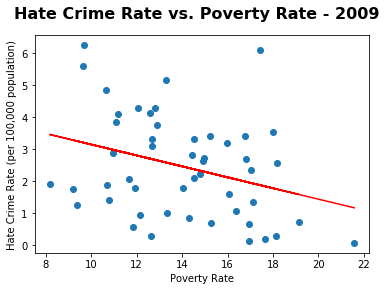

In [31]:
y = clean_hate_crime_2009_df['Hate Crime Rate per 100,000 Population']
x = clean_hate_crime_2009_df['Poverty Rate']

pov_slope, pov_int, pov_r, pov_p, pov_std_err = stats.linregress(
    x, y)
pov_fit = pov_slope * x + pov_int

fig, ax = plt.subplots()

fig.suptitle("Hate Crime Rate vs. Poverty Rate - 2009", fontsize=16, fontweight="bold")
ax.set_ylabel("Hate Crime Rate (per 100,000 population)")
ax.set_xlabel("Poverty Rate")

ax.plot(x, y, linewidth=0, marker='o')
ax.plot(x, pov_fit, 'b-', c='r')

plt.savefig('Images/Hate Crime Rate vs. Poverty Rate - 2009.png')
plt.show()

#### Hate Crime Rate per 100,000 Population vs. Gini Index - 2009

* According to the 2009 data, it seems that as the Gini Index increases (income inequality increases) the hate crime rate increases as well. Income inequality is a known determinant for neighborhood violence and violence in general, of which hate incidents may be considered a special subset.

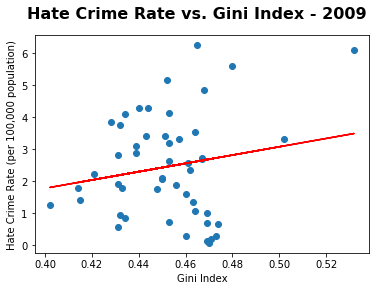

In [43]:
y = clean_hate_crime_2009_df['Hate Crime Rate per 100,000 Population']
x = clean_hate_crime_2009_df['Gini Index']

gini_slope, gini_int, gini_r, gini_p, gini_std_err = stats.linregress(
    x, y)
gini_fit = gini_slope * x + gini_int

fig, ax = plt.subplots()

fig.suptitle("Hate Crime Rate vs. Gini Index - 2009", fontsize=16, fontweight="bold")
ax.set_ylabel("Hate Crime Rate (per 100,000 population)")
ax.set_xlabel("Gini Index")

ax.plot(x, y, linewidth=0, marker='o')
ax.plot(x, gini_fit, 'b-', c='r')

plt.savefig('Images/Hate Crime Rate vs. Gini Index - 2009.png')
plt.show()

# Hate Crime Analysis: 2017

In [33]:
clean_hate_crime_2017_df.describe()

,Total Population,Median Household Income,Per Capita Income,Unemployment Rate,Poverty Rate,Share of Population with HS Diploma,Gini Index_x,Gini Index_y,Hate Crimes Committed,"Hate Crime Rate per 100,000 Population"
count,5.000000e+01,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,6.342890e+06,55712.140000,29688.62000,6.839430,14.212180,0.836921,0.466358,0.466358,146.680000,2.795370
std,7.147839e+06,9218.789409,5020.79553,1.505987,3.019884,0.026322,0.020829,0.020829,202.774474,4.264097
min,5.830290e+05,40528.000000,21651.00000,2.724426,8.262882,0.763152,0.422500,0.422500,4.000000,0.176108
25%,1.854884e+06,48968.500000,26257.25000,5.828424,11.757965,0.821722,0.452700,0.452700,27.250000,0.831500
50%,4.528830e+06,53977.500000,28475.50000,7.139473,14.530672,0.838023,0.466950,0.466950,76.000000,1.893681
75%,6.990395e+06,62142.750000,32725.25000,8.028137,16.388785,0.853971,0.479300,0.479300,161.500000,2.825803
max,3.865421e+07,76067.000000,48781.00000,9.531017,21.596237,0.891784,0.528100,0.528100,1094.000000,29.438141


In [34]:
# Basic stats: 

# Total hate crimes for year (per state).
clean_hate_crime_2017_df['total_crimes_2017'] = clean_hate_crime_2017_df['Hate Crimes Committed'].sum()


# Percent of hate crimes committed per state.
clean_hate_crime_2017_df['share_per_state_2017'] = clean_hate_crime_2017_df['Hate Crimes Committed'] / clean_hate_crime_2017_df['total_crimes_2017'] * 100




summary_2017_df = clean_hate_crime_2017_df[["State", "share_per_state_2017", 'Hate Crimes Committed',
                                            'total_crimes_2017', 'Hate Crime Rate per 100,000 Population'
                                            ]]

summary_2017_df = summary_2017_df.rename(columns={"total_crimes_2017": "Total Hate Crimes",
                                                  "share_per_state_2017": "Share per State (%)"
                                                })

# Add year to DF for merge and group by year analysis.
summary_2017_df['Year'] = '2017'

# Sort by share per state in order to get 
summary_2017_df = summary_2017_df.sort_values(by='Share per State (%)', ascending=False)
summary_2017_df = summary_2017_df.reset_index(drop=True)
summary_2017_df = summary_2017_df.round(2)
summary_2017_df

,State,Share per State (%),Hate Crimes Committed,Total Hate Crimes,"Hate Crime Rate per 100,000 Population",Year
0,California,14.92,1094.0,7334.0,2.83,2017
1,New York,7.55,554.0,7334.0,2.81,2017
2,Washington,6.97,511.0,7334.0,7.22,2017
3,New Jersey,6.80,499.0,7334.0,5.60,2017
4,Michigan,6.23,457.0,7334.0,4.61,2017
5,Massachusetts,5.92,434.0,7334.0,6.44,2017
6,Ohio,5.26,386.0,7334.0,3.33,2017
7,Kentucky,5.15,378.0,7334.0,8.57,2017
8,Arizona,3.60,264.0,7334.0,3.92,2017
9,District of Columbia,2.65,194.0,7334.0,29.44,2017


In [35]:
# Get top 5 states w/ highest count.
max_incidents_2017 = summary_2017_df.head()
top_incident_count_2017 = max_incidents_2017['Hate Crimes Committed'].sum()
top_incident_percent_2017 = max_incidents_2017['Share per State (%)'].sum()
print(f'Total Count of Hate Crimes Among Top 5 in 2017: {top_incident_count_2017}.')
print(f'Total Share of Hate Crimes Among Top 5 in 2017: {top_incident_percent_2017}%.')

Total Count of Hate Crimes Among Top 5 in 2017: 3115.0.
Total Share of Hate Crimes Among Top 5 in 2017: 42.47%.


#### Hate Crime Rate vs. Per Capita Income - 2017

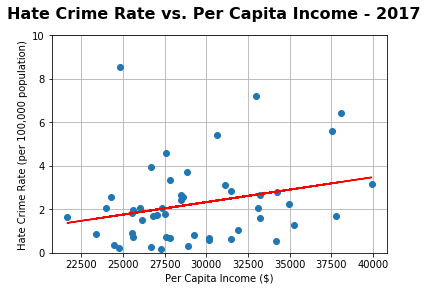

In [36]:
# DC Removed from DF for analysis.
cleaned_hate_crime_2017_df = clean_hate_crime_2017_df.loc[clean_hate_crime_2017_df['State'] != 'District of Columbia']
y = cleaned_hate_crime_2017_df['Hate Crime Rate per 100,000 Population']
x = cleaned_hate_crime_2017_df['Per Capita Income']

pcincome_slope, pcincome_int, pcincome_r, pcincome_p, pcincome_std_err = stats.linregress(
    x, y)
pcincome_fit = pcincome_slope * x + pcincome_int

fig, ax = plt.subplots()

fig.suptitle("Hate Crime Rate vs. Per Capita Income - 2017", fontsize=16, fontweight="bold")
ax.set_ylabel("Hate Crime Rate (per 100,000 population)")
ax.set_xlabel("Per Capita Income ($)")

ax.plot(x, y, linewidth=0, marker='o')
ax.plot(x, pcincome_fit, 'b-', c='r')
ax.grid()

# Remove DC from graph.
plt.ylim(bottom=0, top=10)

plt.savefig('Images/Hate Crime Rate vs. Per Capita Income - 2017.png')
plt.show()

#### Hate Crime Rate per 100,000 Population vs. Median Household Income - 2017

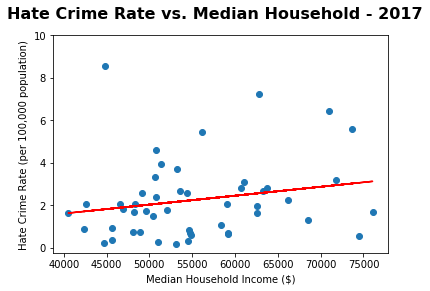

In [37]:
y = cleaned_hate_crime_2017_df['Hate Crime Rate per 100,000 Population']
x = cleaned_hate_crime_2017_df['Median Household Income']

midincome_slope, midincome_int, midincome_r, midincome_p, midincome_std_err = stats.linregress(
    x, y)
midincome_fit = midincome_slope * x + midincome_int

fig, ax = plt.subplots()

fig.suptitle("Hate Crime Rate vs. Median Household - 2017", fontsize=16, fontweight="bold")
ax.set_ylabel("Hate Crime Rate (per 100,000 population)")
ax.set_xlabel("Median Household Income ($)")

ax.plot(x, y, linewidth=0, marker='o')
ax.plot(x, midincome_fit, 'b-', c='r')

# Remove DC from graph.
plt.ylim(top=10)

plt.savefig('Images/Hate Crime Rate vs. Median Household Income - 2017.png')
plt.show()

#### Hate Crime Rate per 100,000 Population vs. Unemployment Rate - 2017

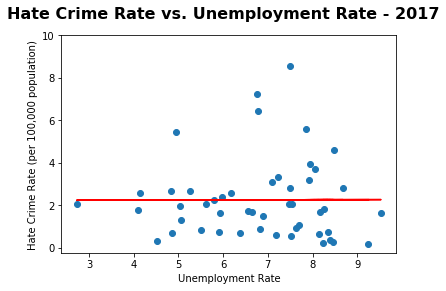

In [38]:
y = cleaned_hate_crime_2017_df['Hate Crime Rate per 100,000 Population']
x = cleaned_hate_crime_2017_df['Unemployment Rate']

unemp_slope, unemp_int, unemp_r, unemp_p, unemp_std_err = stats.linregress(
    x, y)
unemp_fit = unemp_slope * x + unemp_int

fig, ax = plt.subplots()

fig.suptitle("Hate Crime Rate vs. Unemployment Rate - 2017", fontsize=16, fontweight="bold")
ax.set_ylabel("Hate Crime Rate (per 100,000 population)")
ax.set_xlabel("Unemployment Rate")

ax.plot(x, y, linewidth=0, marker='o')
ax.plot(x, unemp_fit, 'b-', c='r')

# Remove DC from graph.
plt.ylim(top=10)

plt.savefig('Images/Hate Crime Rate vs. Unemployment Rate - 2017.png')
plt.show()

#### Hate Crime Rate per 100,000 Population vs. Poverty Rate - 2017

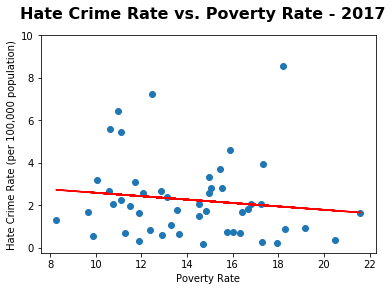

In [39]:
y = cleaned_hate_crime_2017_df['Hate Crime Rate per 100,000 Population']
x = cleaned_hate_crime_2017_df['Poverty Rate']

pov_slope, pov_int, pov_r, pov_p, pov_std_err = stats.linregress(
    x, y)
pov_fit = pov_slope * x + pov_int

fig, ax = plt.subplots()

fig.suptitle("Hate Crime Rate vs. Poverty Rate - 2017", fontsize=16, fontweight="bold")
ax.set_ylabel("Hate Crime Rate (per 100,000 population)")
ax.set_xlabel("Poverty Rate")

ax.plot(x, y, linewidth=0, marker='o')
ax.plot(x, pov_fit, 'b-', c='r')

# Remove DC from graph.
plt.ylim(top=10)

plt.savefig('Images/Hate Crime Rate vs. Poverty Rate - 2017.png')
plt.show()

#### Hate Crime Rate per 100,000 Population vs. Gini Index - 2017

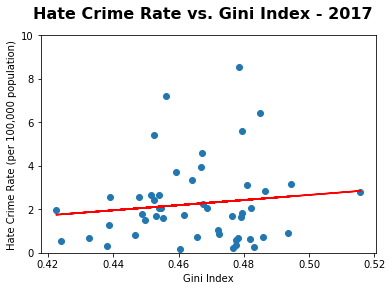

In [45]:
y = cleaned_hate_crime_2017_df['Hate Crime Rate per 100,000 Population']
x = cleaned_hate_crime_2017_df['Gini Index_x']

gini_slope, gini_int, gini_r, gini_p, gini_std_err = stats.linregress(
    x, y)
gini_fit = gini_slope * x + gini_int

fig, ax = plt.subplots()

fig.suptitle("Hate Crime Rate vs. Gini Index - 2017", fontsize=16, fontweight="bold")
ax.set_ylabel("Hate Crime Rate (per 100,000 population)")
ax.set_xlabel("Gini Index")

ax.plot(x, y, linewidth=0, marker='o')
ax.plot(x, gini_fit, 'b-', c='r')

# Remove DC from graph.
plt.ylim(bottom=0, top=10)

plt.savefig('Images/Hate Crime Rate vs. Gini Index - 2017.png')
plt.show()

# Hate Crime Analysis: Share per State - 2009 & 2017

* Hate Crime Rate has increased by 10.92% for country total between 2009 and 2017.

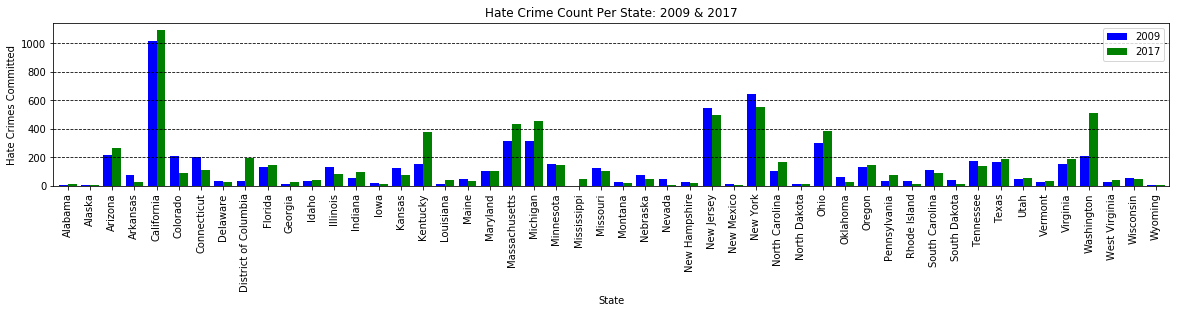

In [46]:
# Sort each DF by State name for alphabetical order.
clean_hate_crime_2009_df = clean_hate_crime_2009_df.sort_values(by=['State'], ascending=True)
clean_hate_crime_2017_df = clean_hate_crime_2017_df.sort_values(by=['State'], ascending=True)

# Hate Crime Counts.
barWidth = .4
states = clean_hate_crime_2009_df['State']
crime_count_2009 = clean_hate_crime_2009_df['Hate Crimes Committed']
crime_count_2017 = clean_hate_crime_2017_df['Hate Crimes Committed']

r1 = np.arange(len(clean_hate_crime_2009_df))
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(20, 3))

plt.bar(r1, crime_count_2009, color='b', alpha=1, align="edge", width=barWidth, label='2009')
plt.bar(r2, crime_count_2017, color='g', alpha=1, align='edge', width=barWidth, label='2017')
plt.xticks([r + barWidth for r in range(len(crime_count_2009))], states, rotation='vertical')

# Set a Title and labels
plt.title('Hate Crime Count Per State: 2009 & 2017')
plt.xlabel('State')
plt.ylabel('Hate Crimes Committed')
plt.grid(axis='y', linestyle='--', color='black')
plt.xlim(-0.25, len(r1))
plt.ylim(0, max(crime_count_2017)+50)
plt.legend()

plt.savefig("Images/Hate_Crime_Count_per_State_2009_2017", bbox_inches='tight')
plt.show()

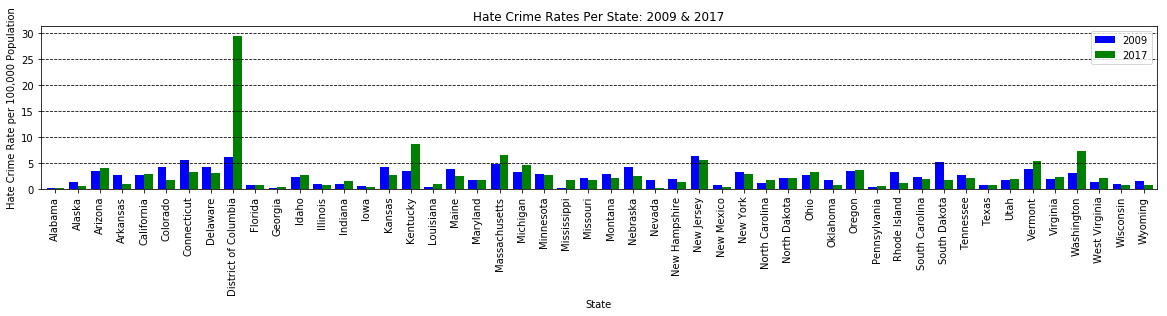

In [38]:
# Hate Crime Rates
barWidth = .4
states = clean_hate_crime_2009_df['State']
crime_rate_2009 = clean_hate_crime_2009_df['Hate Crime Rate per 100,000 Population']
crime_rate_2017 = clean_hate_crime_2017_df['Hate Crime Rate per 100,000 Population']

r1 = np.arange(len(clean_hate_crime_2009_df))
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(20, 3))

plt.bar(r1, crime_rate_2009, color='b', alpha=1, align="edge", width=barWidth, label='2009')
plt.bar(r2, crime_rate_2017, color='g', alpha=1, align='edge', width=barWidth, label='2017')
plt.xticks([r + barWidth for r in range(len(crime_rate_2009))], states, rotation='vertical')

# Set a Title and labels
plt.title('Hate Crime Rates Per State: 2009 & 2017')
plt.xlabel('State')
plt.ylabel('Hate Crime Rate per 100,000 Population')
plt.grid(axis='y', linestyle='--', color='black')
plt.xlim(-0.25, len(r1))
plt.ylim(0, max(crime_rate_2017)+2)
plt.legend()

plt.savefig("Images/Hate_Crime_Rate_per_State_2009_2017", bbox_inches='tight')
plt.show()

In [47]:
# Append the full 2009 and 2017 summary DFs by Hate Crime Rate.
combined_summary_df = summary_2009_df.append(summary_2017_df, ignore_index=True)
combined_summary_df = combined_summary_df.groupby(['Year', 'State']).sum()
combined_summary_df = combined_summary_df.sort_values(by=['Year','Share per State (%)'], ascending=False)
combined_summary_df.head()

In [48]:
# Append the top 5 2009 and 2017 summary DFs by Hate Crimes Committed.
combined_top5_summary_df = max_incidents_2009.append(max_incidents_2017, ignore_index=True)
combined_top5_summary_df = combined_top5_summary_df.groupby(['Year', 'State']).sum()
#combined_top5_summary_df
max_incidents_2009.to_excel('max_incidents_2009.xlsx')
max_incidents_2017.to_excel('max_incidents_2017.xlsx')
#combined_top5_summary_df.to_excel('combined_top5_count.xlsx')

In [49]:
max_rate_2009 = summary_2009_df.sort_values(by='Hate Crime Rate per 100,000 Population', ascending=False)
max_rate_2009 = max_rate_2009.reset_index(drop=True)
max_rate_2009 = max_rate_2009.head()
max_rate_2017 = summary_2017_df.sort_values(by='Hate Crime Rate per 100,000 Population', ascending=False)
max_rate_2017 = max_rate_2017.reset_index(drop=True)
max_rate_2017 = max_rate_2017.head()
max_rate_2009.to_excel('max_rate_2009.xlsx')
max_rate_2017.to_excel('max_rate_2017.xlsx')


# Multiple Linear Regression: 2009

In [50]:
import statsmodels.api as sm

# https://datatofish.com/statsmodels-linear-regression/

x = clean_hate_crime_2009_df[['Per Capita Income']]
y = clean_hate_crime_2009_df['Hate Crime Rate per 100,000 Population']

# Add a constant.
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict(x)

print_model = model.summary()
print(print_model)

                                      OLS Regression Results                                      
Dep. Variable:     Hate Crime Rate per 100,000 Population   R-squared:                       0.284
Model:                                                OLS   Adj. R-squared:                  0.269
Method:                                     Least Squares   F-statistic:                     19.00
Date:                                    Mon, 05 Aug 2019   Prob (F-statistic):           6.86e-05
Time:                                            14:50:38   Log-Likelihood:                -85.810
No. Observations:                                      50   AIC:                             175.6
Df Residuals:                                          48   BIC:                             179.4
Df Model:                                               1                                         
Covariance Type:                                nonrobust                                         
          

C:\Users\zgrin\Anaconda3\envs\PythonData\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


# Multiple Linear Regression: 2017

In [51]:
import statsmodels.api as sm

# https://datatofish.com/statsmodels-linear-regression/

x = clean_hate_crime_2017_df[['Per Capita Income']]
y = clean_hate_crime_2017_df['Hate Crime Rate per 100,000 Population']

# Add a constant.
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict(x)

print_model = model.summary()
print(print_model)

                                      OLS Regression Results                                      
Dep. Variable:     Hate Crime Rate per 100,000 Population   R-squared:                       0.347
Model:                                                OLS   Adj. R-squared:                  0.334
Method:                                     Least Squares   F-statistic:                     25.53
Date:                                    Mon, 05 Aug 2019   Prob (F-statistic):           6.73e-06
Time:                                            14:50:42   Log-Likelihood:                -132.29
No. Observations:                                      50   AIC:                             268.6
Df Residuals:                                          48   BIC:                             272.4
Df Model:                                               1                                         
Covariance Type:                                nonrobust                                         
          

# Hate Crime Analysis: D.C. as an Outlier

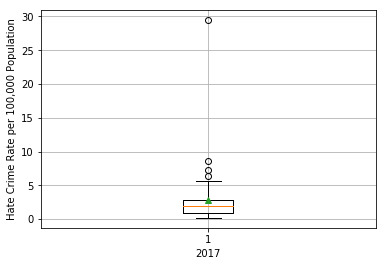

In [52]:
# Box and whisker graph for 2017. 
rate_2017_list = list(clean_hate_crime_2017_df['Hate Crime Rate per 100,000 Population'])
rate_2017_arr = np.array(rate_2017_list)
rate_2017_arr
plt.boxplot(rate_2017_arr, showmeans=True)
plt.grid()
plt.xlabel('2017')
plt.ylabel('Hate Crime Rate per 100,000 Population')

plt.savefig('Images/DC_boxplot_2017.png')

In [53]:
q1 = np.percentile(rate_2017_arr, 25)
q3 = np.percentile(rate_2017_arr,75)

iqr = (q3 - q1)

upper_boundary = q3 + (1.5 * iqr)

print(rate_2017_arr[rate_2017_arr >= upper_boundary])
print('DC, Kentucky, Washington, Mass.')

[29.43814121  8.56756443  6.43712244  7.22450802]
DC, Kentucky, Washington, Mass.
